# XJCO2121 Data Mining - Coursework 2

Author: Tang Shiyu

Student ID: 2022116003

In [26]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [27]:
# Add Chinese stopwords set
stopwords = set()
stopword_files = ['baidu_stopwords', 'cn_stopwords', 'hit_stopwords', 'scu_stopwords']
for file in stopword_files:
    with open(f'stopwords-master/{file}.txt', 'r', encoding='utf-8') as f:
        for line in f:
            word = line.strip()
            if word:
                stopwords.add(word)

def preprocess_text_zh(text):
    # Use jieba to cut the words
    words = jieba.lcut(text)
    filtered_words = [word for word in words if word not in stopwords and len(word.strip()) > 0]
    return ' '.join(filtered_words)

# Define the text divider
def tokenizer(text):
    return jieba.lcut(text)

### This file is for data collecting and processing

For AI-advertisement theme:

In [28]:
files = ['Advertising Planning', 'Additional', 'Brand Marketing']
dfs = []

for file in files:
    # Find the encoding of the file
    with open(f'data/ai-Advertisement/Comments-{file}.csv', 'rb') as f:
        result = chardet.detect(f.read())
    # Read the data
    df = pd.read_csv(f'data/ai-Advertisement/Comments-{file}.csv', encoding=result['encoding'], encoding_errors='replace')
    # Check the data
    print(f'The number of data in {file} is {len(df)}')
    # Delete the unneeded columns
    df = df.drop(columns=['ip_location', 'note_id', 'user_id', 'avatar', 'pictures', 'parent_comment_id', 'last_modify_ts'])
    dfs.append(df)
# Merging all data in this theme
df_ad = pd.concat(dfs)
# Delete the data with the same comment_id
df_ad = df_ad.drop_duplicates(subset=['comment_id'])
print(f'After deleting repeated data, the number of data is {len(df_ad)}')
# Fill in the missing nickname
df_ad = df_ad.fillna('匿名用户')
display(df_ad.head())
display(df_ad.info())
display(df_ad.describe())

The number of data in Advertising Planning is 7514
The number of data in Additional is 7744
The number of data in Brand Marketing is 3739
After deleting repeated data, the number of data is 10539


,comment_id,create_time,content,nickname,sub_comment_count,like_count,sentiment
0,667408e60000000017012a2a,1718880488000,还好我boss不懂看我出单还表扬我了,木子,131.0,31.0,negative
1,66596c33000000000f0077bc,1717136435000,做的好棒！,豆花要加糖,4.0,2.0,positive
2,665961c1000000000e033c6c,1717133762000,真诚发问这个豆奶口感咋样好喝吗早八人很需要啊宝子,小红薯62E23D58,3.0,2.0,positive
3,667978b100000000150082e2,1719236785000,求分享,捞起月亮的渔民,1.0,0.0,positive
4,665975d0000000001b007630,1717138897000,哇塞你们画的也太多了吧,小红薯63E82F05,3.0,1.0,negative


<class 'pandas.core.frame.DataFrame'>
Index: 10539 entries, 0 to 3704
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   comment_id         10539 non-null  object 
 1   create_time        10539 non-null  int64  
 2   content            10539 non-null  object 
 3   nickname           10539 non-null  object 
 4   sub_comment_count  10539 non-null  float64
 5   like_count         10539 non-null  float64
 6   sentiment          10539 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 658.7+ KB


None

,create_time,sub_comment_count,like_count
count,1.053900e+04,10539.000000,10539.000000
mean,1.716603e+12,0.492741,4.038808
std,1.244362e+10,5.515641,123.713814
min,1.640227e+12,0.000000,0.000000
25%,1.711402e+12,0.000000,0.000000
50%,1.719459e+12,0.000000,0.000000
75%,1.726363e+12,1.000000,1.000000
max,1.728960e+12,427.000000,8803.000000


sentiment
negative    5449
positive    5090
Name: count, dtype: int64


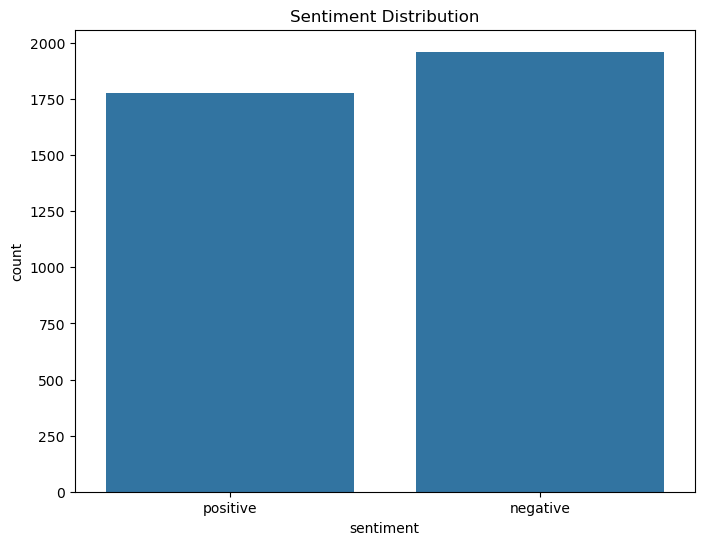

In [29]:
# Check the distribution of the sentiment
sentiment_distribution = df_ad['sentiment'].value_counts()
print(sentiment_distribution)

plt.figure(figsize=(8,6))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

In [30]:
df_ad['processed_content'] = df_ad['content'].apply(preprocess_text_zh)
# Process the TF-IDF vectors
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenizer, token_pattern=None, max_features=5000)
X = vectorizer.fit_transform(df_ad['processed_content'])

In [33]:
# Split the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(X, df_ad['sentiment'], test_size=0.2, random_state=1)
# Train the model
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
# Test the model
predictions = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))

Accuracy: 0.8614800759013282

Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.88      0.87      1071
    positive       0.87      0.85      0.86      1037

    accuracy                           0.86      2108
   macro avg       0.86      0.86      0.86      2108
weighted avg       0.86      0.86      0.86      2108


Confusion Matrix:
 [[938 133]
 [159 878]]


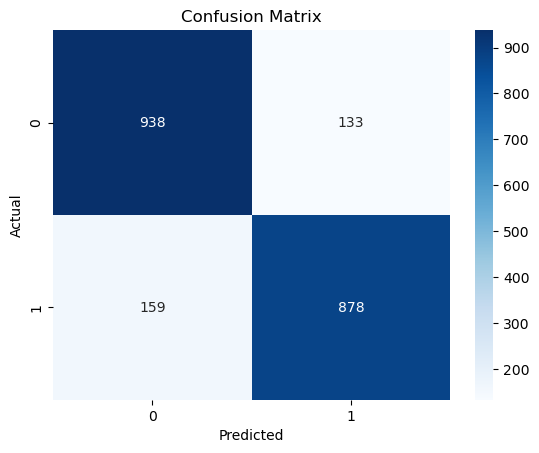

In [34]:
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()